# PyTorchで画像分類
## MLPによるのCIFAR10分類
## ミニバッチ学習
## （ローカルPC上でCPU or GPU） or AWSクラウドGPU の利用

In [1]:
import torch#tensorを作成・操作するための機能、GPUの仕様も設定
import torch.nn as nn#nnを構成する部品を提供
import torch.optim as optim#SGD,adamなどの最適化関数や学習率を設定
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
# もしGPUが利用可能なら cuda が入る
device = "cuda" if torch.cuda.is_available() else "cpu"
print('学習に使用するデバイス：',device)

学習に使用するデバイス： cuda


# 前処理の定義 

In [3]:
train_dataset = datasets.CIFAR10(
    root="./data", 
    train=True, download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified


In [4]:
test_dataset = datasets.CIFAR10(
    root="./data", 
    train=False, download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified


In [5]:
img,label = train_dataset[39]
print(img.size())
print(label)

torch.Size([3, 32, 32])
3


# ミニバッチのサイズを決める
### バッチ学習：60000 枚を一度に学習する
### ミニバッチ学習：例えば 60000 枚を 100 枚ずつに分けて学習する

In [6]:
num_batches = 100

In [7]:
# 100個ごとに画像と教師データをセットにして train_dataloaderに入れる
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=num_batches, 
    shuffle=True
)
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
# 100個ごとに画像と教師データをセットにして train_dataloaderに入れる
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=num_batches, 
    shuffle=False
)
test_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
imgs.size()

torch.Size([100, 3, 32, 32])

In [10]:
labels # 正解ラベルの確認

tensor([2, 7, 5, 5, 9, 6, 9, 9, 5, 4, 1, 6, 5, 8, 2, 9, 8, 3, 9, 9, 5, 2, 9, 9,
        9, 1, 6, 9, 1, 1, 2, 2, 0, 1, 1, 4, 3, 3, 6, 7, 4, 2, 8, 2, 9, 6, 7, 8,
        8, 2, 7, 9, 5, 0, 5, 3, 4, 0, 5, 3, 1, 1, 4, 2, 0, 2, 5, 4, 1, 6, 3, 7,
        1, 5, 7, 4, 3, 2, 6, 3, 1, 3, 1, 1, 5, 9, 5, 5, 1, 4, 7, 0, 5, 0, 7, 5,
        6, 8, 3, 2])

# ネットワークモデルの定義

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3*32 * 32, 600),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0,2),
            nn.Linear(600, 600),
            nn.ReLU(inplace=True),
            nn.Linear(600, 10),
            nn.ReLU(inplace=True),

        )
    def forward(self, x):
        output = self.classifier(x)
        return output

In [14]:
model = MLP()
net = model.to(device)

# 損失関数、最適化関数の定義

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 学習

In [16]:
%%time
num_epochs = 400
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    net.train()

    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_batches, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)

        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)

        loss.backward()

        optimizer.step()

    running_loss /= len(train_dataloader)
    losses.append(running_loss)

    print("epoch: {}, loss: {}".format(epoch, running_loss))

epoch: 0, loss: 2.2780460176467896
epoch: 1, loss: 2.222033371448517
epoch: 2, loss: 2.172431688785553
epoch: 3, loss: 2.1164715378284455
epoch: 4, loss: 2.0581098670959475
epoch: 5, loss: 2.0217964968681335
epoch: 6, loss: 1.928735027551651
epoch: 7, loss: 1.849016846179962
epoch: 8, loss: 1.816919284582138
epoch: 9, loss: 1.7894398176670074
epoch: 10, loss: 1.7669564740657806
epoch: 11, loss: 1.7452970690727234
epoch: 12, loss: 1.7245732789039612
epoch: 13, loss: 1.7043749513626099
epoch: 14, loss: 1.685697230577469
epoch: 15, loss: 1.669877507686615
epoch: 16, loss: 1.6553406014442444
epoch: 17, loss: 1.6387480006217956
epoch: 18, loss: 1.6211267189979552
epoch: 19, loss: 1.6095947177410126
epoch: 20, loss: 1.5981989705562591
epoch: 21, loss: 1.5824703829288482
epoch: 22, loss: 1.567874300956726
epoch: 23, loss: 1.5582439868450164
epoch: 24, loss: 1.5459020698070527
epoch: 25, loss: 1.533275943517685
epoch: 26, loss: 1.522409946203232
epoch: 27, loss: 1.5131111004352569
epoch: 28, l

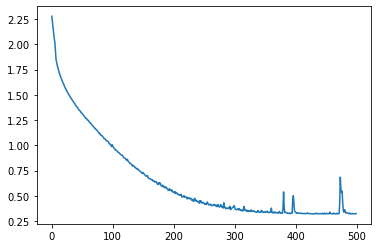

In [23]:
plt.plot(losses) # 誤差が減少していることを確認

# テスト

# 正解ラベル

In [24]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
labels

tensor([1, 5, 2, 6, 3, 6, 5, 1, 2, 5, 3, 3, 9, 1, 3, 3, 7, 2, 3, 5, 9, 6, 8, 9,
        6, 1, 3, 2, 3, 7, 4, 0, 9, 0, 8, 6, 0, 4, 2, 7, 9, 4, 7, 9, 8, 2, 9, 3,
        5, 7, 3, 4, 3, 3, 6, 3, 3, 5, 1, 1, 3, 3, 1, 3, 2, 6, 0, 5, 4, 0, 2, 1,
        9, 9, 8, 1, 3, 8, 4, 8, 9, 4, 3, 8, 9, 8, 8, 2, 8, 1, 8, 0, 0, 4, 6, 0,
        2, 8, 8, 0])

# 予測結果

In [25]:
imgs_gpu = imgs.view(100, -1).to(device)
output= model(imgs_gpu)
pred = torch.argmax(output, dim=1)
pred

tensor([1, 7, 2, 6, 3, 6, 7, 1, 2, 7, 3, 3, 9, 1, 3, 3, 7, 2, 3, 7, 9, 6, 8, 9,
        6, 1, 3, 2, 3, 7, 4, 0, 9, 0, 7, 6, 0, 4, 2, 7, 9, 4, 7, 9, 8, 2, 9, 3,
        7, 7, 3, 7, 3, 2, 6, 3, 3, 7, 1, 1, 3, 3, 1, 3, 2, 7, 0, 7, 4, 0, 2, 1,
        9, 9, 8, 1, 3, 8, 4, 8, 9, 4, 3, 8, 9, 8, 8, 2, 8, 1, 8, 0, 0, 4, 6, 0,
        2, 8, 8, 0], device='cuda:0')

In [ ]:
s = 0

for imgs, labels in test_dataloader:
    labels = labels.to(device)
    imgs_gpu = imgs.view(num_batches, -1).to(device)
    output = model(imgs_gpu)
    pred = torch.argmax(output, dim=1)
    s += sum(labels==pred)
    
int(s)/100